In [29]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from nmt_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████| 10000/10000 [00:00<00:00, 19700.45it/s]


In [31]:
dataset[:10]

[('3 january 1991', '1991-01-03'),
 ('tuesday june 30 2009', '2009-06-30'),
 ('tuesday may 31 2011', '2011-05-31'),
 ('9/2/77', '1977-09-02'),
 ('sunday october 15 1989', '1989-10-15'),
 ('friday february 1 2008', '2008-02-01'),
 ('18 dec 1978', '1978-12-18'),
 ('22 03 94', '1994-03-22'),
 ('thursday july 4 2002', '2002-07-04'),
 ('sunday november 18 1990', '1990-11-18')]

In [32]:
Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)


In [33]:
index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])
print()
print("Source after preprocessing (one-hot):", Xoh[index])
print("Target after preprocessing (one-hot):", Yoh[index])

Source date: 3 january 1991
Target date: 1991-01-03

Source after preprocessing (indices): [ 6  0 22 13 25 31 13 28 34  0  4 12 12  4 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36]
Target after preprocessing (indices): [ 2 10 10  2  0  1  2  0  1  4]

Source after preprocessing (one-hot): [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]]
Target after preprocessing (one-hot): [[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]

In [34]:
# Defined shared layers as global variables
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') 
dotor = Dot(axes = 1)

In [35]:


def one_step_attention(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.
    
    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- context vector, input of the next (post-attention) LSTM cell
    """
    
    s_prev = repeator(s_prev)
    concat = concatenator([a, s_prev])    
    e = densor1(concat)
    energies = densor2(e)
    alphas = activator(energies)
    context = dotor([alphas, a])

    
    return context

You will be able to check the expected output of `one_step_attention()` after you've coded the `model()` function.

#### model
* `model` first runs the input through a Bi-LSTM to get $[a^{<1>},a^{<2>}, ..., a^{<T_x>}]$. 
* Then, `model` calls `one_step_attention()` $T_y$ times using a `for` loop.  At each iteration of this loop:
    - It gives the computed context vector $context^{<t>}$ to the post-attention LSTM.
    - It runs the output of the post-attention LSTM through a dense layer with softmax activation.
    - The softmax generates a prediction $\hat{y}^{<t>}$. 

**Exercise**: Implement `model()` as explained in figure 1 and the text above. Again, we have defined global layers that will share weights to be used in `model()`.

In [36]:
n_a = 32 # number of units for the pre-attention, bi-directional LSTM's hidden state 'a'
n_s = 64 # number of units for the post-attention LSTM's hidden state "s"

post_activation_LSTM_cell = LSTM(n_s, return_state = True) # post-attention LSTM 
output_layer = Dense(len(machine_vocab), activation=softmax)

In [37]:
def model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    human_vocab_size -- size of the python dictionary "human_vocab"
    machine_vocab_size -- size of the python dictionary "machine_vocab"

    Returns:
    model -- Keras model instance
    """

    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    outputs = []
    
    a = Bidirectional(LSTM(n_a, return_sequences = True), input_shape = (m, Tx, n_a * 2))(X)
    
    for t in range(Ty):
    
        # Step 2.A: Perform one step of the attention mechanism to get back the context vector at step t
        context = one_step_attention(a, s)
        
        # Step 2.B: Apply the post-attention LSTM cell to the "context" vector.
        s, _, c = post_activation_LSTM_cell(context, initial_state = [s, c])
        
        # Step 2.C: Apply Dense layer to the hidden state output of the post-attention LSTM
        out = output_layer(s)
        
        # Step 2.D: Append "out" to the "outputs" list
        outputs.append(out)
    
    # Step 3: Create model instance taking three inputs and returning the list of outputs
    model = Model(inputs = [X, s0, c0], outputs = outputs)
    
    
    return model

In [38]:
model = model(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))

In [39]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 30, 37)        0                                            
____________________________________________________________________________________________________
s0 (InputLayer)                  (None, 64)            0                                            
____________________________________________________________________________________________________
bidirectional_5 (Bidirectional)  (None, 30, 64)        17920       input_6[0][0]                    
____________________________________________________________________________________________________
repeat_vector_2 (RepeatVector)   (None, 30, 64)        0           s0[0][0]                         
                                                                   lstm_7[0][0]            

In [40]:
opt = Adam(lr = 0.005, beta_1 = 0.9, beta_2 = 0.999, decay = 0.01)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [48]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))

In [49]:
model.fit([Xoh, s0, c0], outputs, epochs=1, batch_size=100)

Epoch 1/1
10000/10000 [==============================] - 49s - loss: 1.1632 - dense_7_loss_1: 0.0152 - dense_7_loss_2: 0.0076 - dense_7_loss_3: 0.0613 - dense_7_loss_4: 0.1439 - dense_7_loss_5: 0.0270 - dense_7_loss_6: 0.0682 - dense_7_loss_7: 0.1844 - dense_7_loss_8: 0.0343 - dense_7_loss_9: 0.4134 - dense_7_loss_10: 0.2080 - dense_7_acc_1: 0.9955 - dense_7_acc_2: 0.9980 - dense_7_acc_3: 0.9836 - dense_7_acc_4: 0.9657 - dense_7_acc_5: 0.9944 - dense_7_acc_6: 0.9832 - dense_7_acc_7: 0.9600 - dense_7_acc_8: 0.9943 - dense_7_acc_9: 0.9185 - dense_7_acc_10: 0.9582    


In [50]:
model.load_weights('models/model.h5')

In [51]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
for example in EXAMPLES:
    
    source = string_to_int(example, Tx, human_vocab)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source))).swapaxes(0,1)
    prediction = model.predict([source, s0, c0])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    
    print("source:", example)
    print("output:", ''.join(output),"\n")

source: 3 May 1979
output: 1979-05-03 

source: 5 April 09
output: 2009-05-05 

source: 21th of August 2016
output: 2016-08-21 

source: Tue 10 Jul 2007
output: 2007-07-10 

source: Saturday May 9 2018
output: 2018-05-09 

source: March 3 2001
output: 2001-03-03 

source: March 3rd 2001
output: 2001-03-03 

source: 1 March 2001
output: 2001-03-01 



In [45]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 30, 37)        0                                            
____________________________________________________________________________________________________
s0 (InputLayer)                  (None, 64)            0                                            
____________________________________________________________________________________________________
bidirectional_5 (Bidirectional)  (None, 30, 64)        17920       input_6[0][0]                    
____________________________________________________________________________________________________
repeat_vector_2 (RepeatVector)   (None, 30, 64)        0           s0[0][0]                         
                                                                   lstm_7[0][0]            

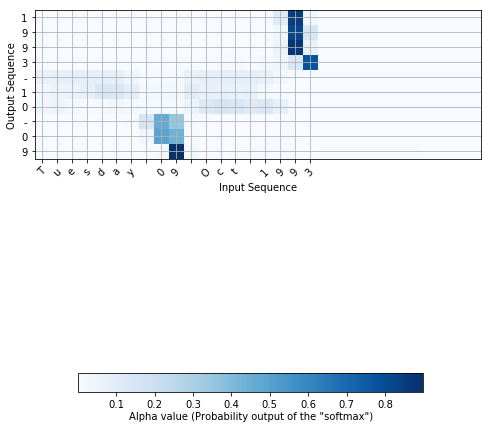

In [46]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "Tuesday 09 Oct 1993", num = 7, n_s = 64);